<a href="https://colab.research.google.com/github/saro0307/Email-Spam-Detection-/blob/main/Email_Spam_Detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
# Set the style of the visualization
import seaborn as sns
import matplotlib.pyplot as plt

# import text preprocessing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
data = pd.read_csv('/content/spam_ham_dataset.csv')
data

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [ ]:
# Check for duplicate rows in the upsampled dataset
duplicate_rows = data[data.duplicated()]

# Display the number of duplicate rows
num_duplicates = len(duplicate_rows)
num_duplicates

0

In [ ]:
# Drop the 'v1' column
data_cleaned = data.drop(columns=['Unnamed: 0','label'])

# Display the first few rows of the updated dataset
data_cleaned.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
# Calculate the length of each message
data_cleaned['text_length'] = data_cleaned['text'].apply(len)

# Calculate basic statistics for the lengths of messages in both "ham" and "spam" categories
stats = data_cleaned.groupby('label_num')['text_length'].describe()

stats

,count,mean,std,min,25%,50%,75%,max
label_num,,,,,,,,
0,3672.0,977.008170,1382.827493,18.0,231.75,530.0,1227.25,32258.0
1,1499.0,1223.256171,1825.986210,11.0,283.00,576.0,1253.50,22073.0


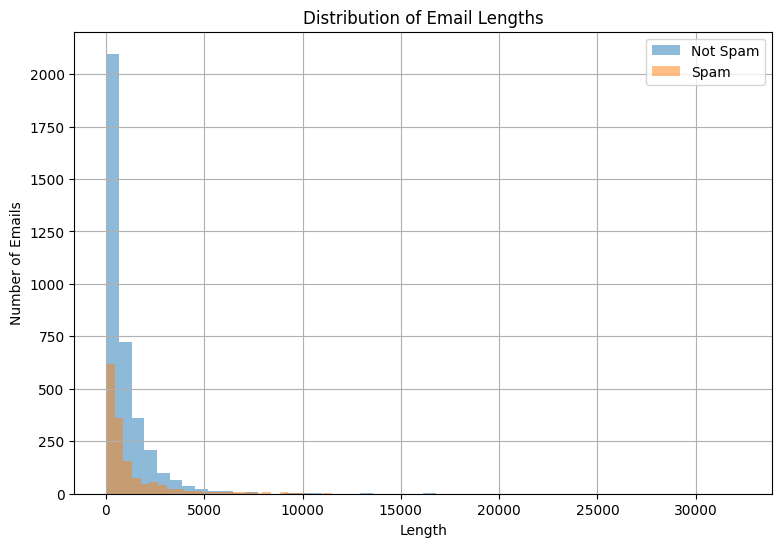

In [ ]:
# Visualize the distribution of email lengths for both spam and non-spam categories
plt.figure(figsize=(9, 6))
plt.hist(data_cleaned[data_cleaned['label_num'] == 0]['text_length'], bins=50, alpha=0.5, label='Not Spam')
plt.hist(data_cleaned[data_cleaned['label_num'] == 1]['text_length'], bins=50, alpha=0.5, label='Spam')
plt.title('Distribution of Email Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Emails')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

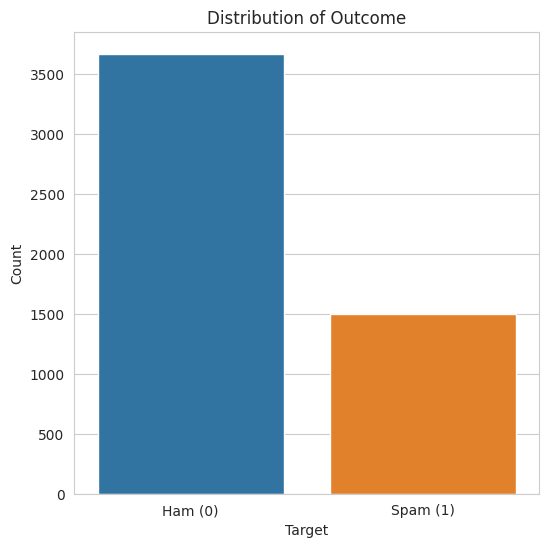

In [ ]:
sns.set_style("whitegrid")

# Draw a bar plot of 'Outcome' value counts
plt.figure(figsize=(6, 6))
sns.countplot(x='label_num', data=data_cleaned)
plt.title('Distribution of Outcome')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['Ham (0)', 'Spam (1)'])
plt.show()

In [ ]:
from sklearn.utils import resample

# Separate the majority and minority classes
df_majority = data_cleaned[data_cleaned['label_num'] == 0]
df_minority = data_cleaned[data_cleaned['label_num'] == 1]

# Oversample the minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=len(df_majority),
                                 random_state=42)

# Combine the majority class with the upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Check the distribution of the labels in the upsampled dataset
upsampled_label_distribution = df_upsampled['label_num'].value_counts(normalize=True)

upsampled_label_distribution


0    0.5
1    0.5
Name: label_num, dtype: float64

In [ ]:
df_upsampled

,text,label_num,text_length
0,Subject: enron methanol ; meter # : 988291\r\n...,0,327
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524
4,Subject: re : indian springs\r\nthis deal is t...,0,336
5,Subject: ehronline web address change\r\nthis ...,0,480
...,...,...,...
90,"Subject: vulgar\r\nmuniz ,\r\ngovenment don ' ...",1,275
4773,"Subject: confidence is back\r\nhello ,\r\nmy b...",1,684
2475,"Subject: hey ,\r\nhello , it ' s me lauren . ....",1,283
3289,"Subject: cheap v . iagra , phentermine , xa . ...",1,459


In [ ]:
# Download the stopwords and punkt (used for tokenization) from nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Load the list of stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers and punctuation
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

df_upsampled['preprocessed_msg'] = df_upsampled['text'].apply(clean_text)

# Display the first few rows after cleaning
df_upsampled.head()

,text,label_num,text_length,preprocessed_msg
0,Subject: enron methanol ; meter # : 988291\r\n...,0,327,"[subject, enron, methanol, meter, follow, note..."
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97,"[subject, hpl, nom, january, see, attached, fi..."
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,"[subject, neon, retreat, ho, ho, ho, around, w..."
4,Subject: re : indian springs\r\nthis deal is t...,0,336,"[subject, indian, springs, deal, book, teco, p..."
5,Subject: ehronline web address change\r\nthis ...,0,480,"[subject, ehronline, web, address, change, mes..."


In [ ]:
# Initialize the stemmer
stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

# Apply stemming to the tokens
df_upsampled['stemmed_tokens'] = df_upsampled['preprocessed_msg'].apply(stem_tokens)

# Display the first few rows of the dataset after stemming
df_upsampled.head()

,text,label_num,text_length,preprocessed_msg,stemmed_tokens
0,Subject: enron methanol ; meter # : 988291\r\n...,0,327,"[subject, enron, methanol, meter, follow, note...","[subject, enron, methanol, meter, follow, note..."
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,97,"[subject, hpl, nom, january, see, attached, fi...","[subject, hpl, nom, januari, see, attach, file..."
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,2524,"[subject, neon, retreat, ho, ho, ho, around, w...","[subject, neon, retreat, ho, ho, ho, around, w..."
4,Subject: re : indian springs\r\nthis deal is t...,0,336,"[subject, indian, springs, deal, book, teco, p...","[subject, indian, spring, deal, book, teco, pv..."
5,Subject: ehronline web address change\r\nthis ...,0,480,"[subject, ehronline, web, address, change, mes...","[subject, ehronlin, web, address, chang, messa..."


In [ ]:
import numpy as np
from gensim.models import Word2Vec

# Tokenize the cleaned text
sentences = df_upsampled['stemmed_tokens'].tolist()

# Train a Word2Vec model with reduced alpha (e.g., alpha=0.025)
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, alpha=0.5)
word2vec_model.train(sentences, total_examples=len(sentences), epochs=10)

# Get the vocabulary of the model
vocab = set(word2vec_model.wv.index_to_key)

# Function to convert an SMS message into a vector (by averaging the vectors of its words)
def message_to_vector(message):
    words = [word for word in message if word in vocab]
    if len(words) == 0:
        return np.zeros(100)  # Return a zero vector if no words in vocab
    return np.mean([word2vec_model.wv[word] for word in words], axis=0)

# Transform the cleaned text data into vectors
df_upsampled['vectorized_df'] = [message_to_vector(msg) for msg in sentences]

# Now df_upsampled contains the original data along with word vectors in the 'vectorized_df' column.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score,roc_curve, auc, confusion_matrix

In [ ]:
# Splitting the dataset into training and testing sets
X = list(df_upsampled['vectorized_df'])
y = df_upsampled['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
# Predicting on the test set
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9530292716133424

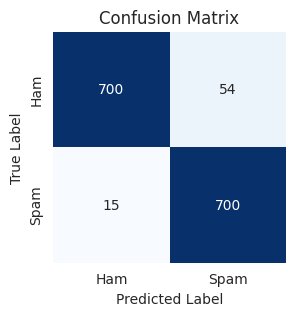

              precision    recall  f1-score   support

         Ham       0.98      0.93      0.95       754
        Spam       0.93      0.98      0.95       715

    accuracy                           0.95      1469
   macro avg       0.95      0.95      0.95      1469
weighted avg       0.95      0.95      0.95      1469



In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate and display the classification report
class_report = classification_report(y_test, y_pred, target_names=['Ham', 'Spam'])

print(class_report)

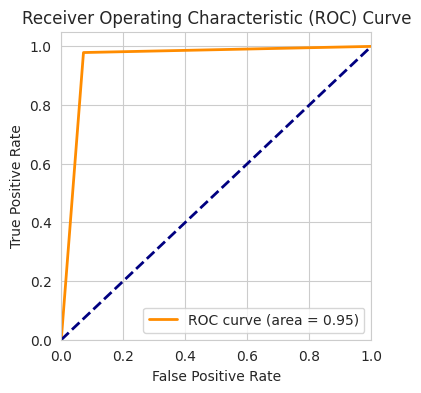

In [ ]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()